In [7]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import train_test_split

In [2]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [3]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [24]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels, max_features = None):
    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]
    features = np.random.choice(range(n_features), max_features, replace=False) if max_features else range(n_features)

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 3 объектов
            #if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
            #    continue

            current_gain = gain(true_labels, false_labels, root_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [41]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

    #print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)

    #print(time.time(), false_branch)

    #Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [55]:
def build_tree_with_criteria(data, labels, max_depth=None, min_samples_leaf=1, max_features=None, depth=0):
    print(max_depth)
    print(min_samples_leaf)
    print(max_features)
    print(depth)
    gain, t, index = find_best_split(data, labels, max_features)
    if gain == 0 or (max_depth is not None and depth >= max_depth) or len(labels) <= min_samples_leaf:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree_with_criteria(true_data, true_labels, max_depth, min_samples_leaf, max_features, depth + 1)
    false_branch = build_tree_with_criteria(false_data, false_labels, max_depth, min_samples_leaf, max_features, depth + 1)

    return Node(index, t, true_branch, false_branch)


In [6]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


In [13]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [9]:
df_full = pd.read_csv('cardio.csv', sep=';')

features = ['age', 'height']
target = ['cardio']

df = df_full[features + target]
print(df_full)
print(df.shape)

          id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0          0   50       2     168    62.0    110     80            1     1   
1          1   55       1     156    85.0    140     90            3     1   
2          2   51       1     165    64.0    130     70            3     1   
3          3   48       2     169    82.0    150    100            1     1   
4          4   47       1     156    56.0    100     60            1     1   
...      ...  ...     ...     ...     ...    ...    ...          ...   ...   
69995  99993   52       2     168    76.0    120     80            1     1   
69996  99995   61       1     158   126.0    140     90            2     2   
69997  99996   52       2     183   105.0    180     90            3     1   
69998  99998   61       1     163    72.0    135     80            1     2   
69999  99999   56       1     170    72.0    120     80            2     1   

       smoke  alco  active  cardio  
0          0     0       1

In [20]:
classification_data, classification_labels = make_classification(
    n_features=2,
    n_informative=2,
    n_classes=4,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42)

classification_data, classification_labels = make_circles(
    n_samples=100,
    random_state=42)

train_data, test_data, train_labels, test_labels = train_test_split(
    classification_data,
    classification_labels,
    test_size=0.3,
    random_state=1)

# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [59]:
tree_no_criteria = build_tree(train_data, train_labels)
tree_with_criteria = build_tree_with_criteria(train_data, train_labels, max_depth=5, min_samples_leaf=1, max_features=2)

train_preds_no_criteria = predict(train_data, tree_no_criteria)
test_preds_no_criteria = predict(test_data, tree_no_criteria)

train_preds_with_criteria = predict(train_data, tree_with_criteria)
test_preds_with_criteria = predict(test_data, tree_with_criteria)

train_accuracy_no_criteria = accuracy_metric(train_labels, train_preds_no_criteria)
test_accuracy_no_criteria = accuracy_metric(test_labels, test_preds_no_criteria)

train_accuracy_with_criteria = accuracy_metric(train_labels, train_preds_with_criteria)
test_accuracy_with_criteria = accuracy_metric(test_labels, test_preds_with_criteria)


5
1
2
0
5
1
2
1
5
1
2
1
5
1
2
2
5
1
2
2
5
1
2
3
5
1
2
4
5
1
2
5
5
1
2
5
5
1
2
4
5
1
2
3


In [60]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print(spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print(spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [61]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (12, 6))

    # график обучающей выборки без критериев
    plt.subplot(2,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], tree_no_criteria)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy without criteria={train_accuracy_no_criteria:.2f}')

    # график тестовой выборки без критериев
    plt.subplot(2,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy without criteria={test_accuracy_no_criteria:.2f}')

    # график обучающей выборки с критериями
    plt.subplot(2,2,3)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions_criteria = np.array(predict(np.c_[xx.ravel(), yy.ravel()], tree_with_criteria)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions_criteria, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy with criteria={train_accuracy_with_criteria:.2f}')

    # график тестовой выборки с критериями
    plt.subplot(2,2,4)
    plt.pcolormesh(xx, yy, mesh_predictions_criteria, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy with criteria={test_accuracy_with_criteria:.2f}')

    plt.tight_layout()
    plt.show()

Train accuracy without criteria: 100.0
Test accuracy without criteria: 96.66666666666667
Train accuracy with criteria: 92.85714285714286
Test accuracy with criteria: 90.0


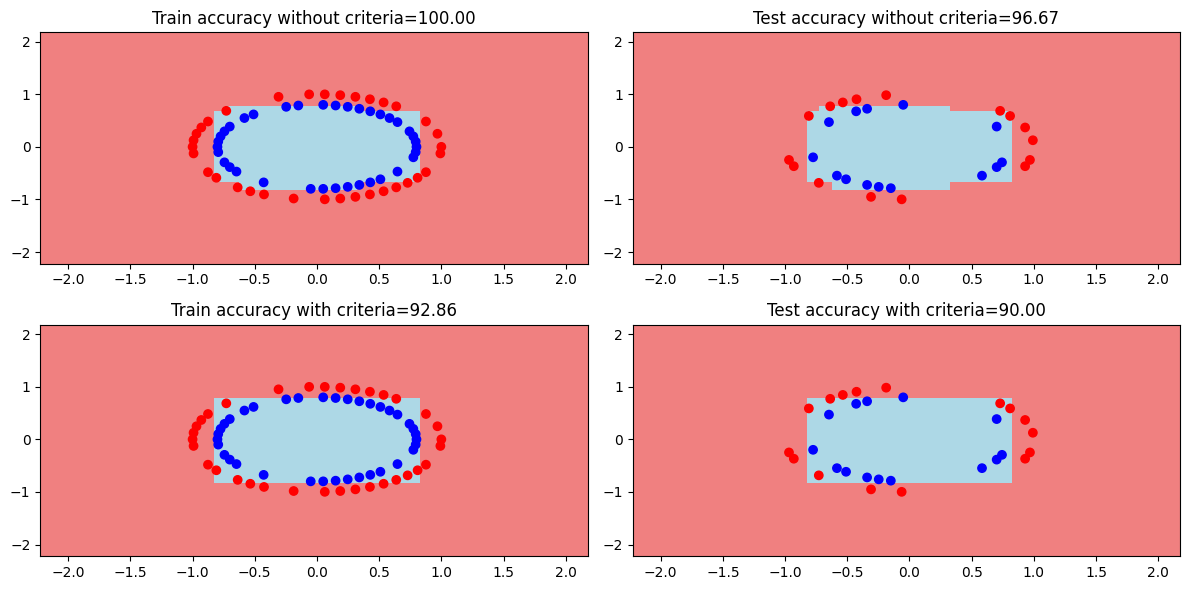

In [62]:
print(f'Train accuracy without criteria: {train_accuracy_no_criteria}')
print(f'Test accuracy without criteria: {test_accuracy_no_criteria}')
print(f'Train accuracy with criteria: {train_accuracy_with_criteria}')
print(f'Test accuracy with criteria: {test_accuracy_with_criteria}')
visualize(train_data, test_data)